# **Import Library yang dibutuhkan**

In [1]:
# Mengimport Library yang dibutuhkan

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Import Library yang dibutuhkan

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import NotFittedError

# **Load Dataset**

In [2]:
# Load Dataset

df = pd.read_csv("/content/drive/MyDrive/Dataset Ulasan Google Play/scrapped_data_wuwa_v1.csv")
df.head()

,userName,at,content
0,Bima,2024-10-30 01:22:05,Mbut
1,Yusuf Abbdullah,2024-10-30 01:02:11,I change my device and ITS was the best game ever
2,Mr. Rokugatsu,2024-10-30 00:42:05,"need material (core) for ascend weapon, resona..."
3,Akmal Nur Hakim,2024-10-29 16:06:24,"cons :game nya oke, story oke, hp dan grafik k..."
4,Arya,2024-10-29 15:19:22,"Saya suka sama grafik,story,dan mekanisme game..."


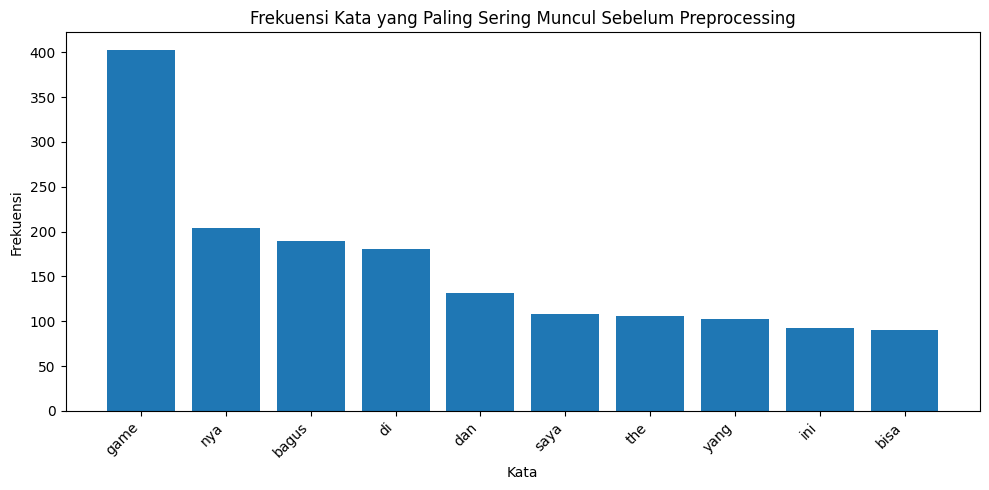

In [3]:
from collections import Counter

# Gabungkan semua teks ulasan menjadi satu string
all_text = ' '.join(df['content'].astype(str).tolist())

# Hapus karakter non-alfanumerik dan ubah menjadi huruf kecil
all_text = re.sub(r'[^a-zA-Z0-9\s]', '', all_text).lower()

# Pisahkan teks menjadi kata-kata
words = all_text.split()

# Hitung frekuensi kemunculan setiap kata
word_counts = Counter(words)

# Ambil 10 kata yang paling sering muncul
most_common_words = word_counts.most_common(10)

# Buat bar chart
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kata yang Paling Sering Muncul Sebelum Preprocessing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# Menampilkan Column Content, Username, dan at.

df = df[['content']]
df

,content
0,Mbut
1,I change my device and ITS was the best game ever
2,"need material (core) for ascend weapon, resona..."
3,"cons :game nya oke, story oke, hp dan grafik k..."
4,"Saya suka sama grafik,story,dan mekanisme game..."
...,...
995,The best story 😁
996,keren
997,Game terbaik yg pernah aku temukan
998,bagus


In [5]:
# Memberikan Informasi terkait Dataset yang digunakan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [6]:
# Menghasilkan statistik deskriptif data dalam Pandas DataFrame atau Series.

df.describe()


,content
count,1000
unique,900
top,mantap
freq,14


# **Pre - Processing**


1.   Cleaning Data
2.   Case Folding
3.   Normalization
4.   Stopword
5.   Tokenize
6.   Stemming
7.   Translate
8.   Labeling

## **Cleaning Data & Case Folding**

In [7]:
# Mengetahui jumlah berapa baris dan kolom.

df.shape

(1000, 1)

In [8]:
# Menghapus data yang duplicate

df = df.drop_duplicates(subset=['content'])

In [9]:
# Mengecek data yang duplikat

df.duplicated().sum()

0

In [10]:
# Menghapus data yang kosong

df = df.dropna()

In [11]:
# Memastikan tidak ada missing value yang tersisa.

df.isnull().sum()

,0
content,0


In [12]:
# Mengetahui jumlah berapa baris dan kolom setelahnya

df.shape

(900, 1)

In [13]:
# Fungsi Cleaning Text

def clean_review_text(text): # Membuat Fungsi Cleaning Text
  text = re.sub(r"@[A-Za-z0-9_]+", "", text) # Menghapus Mention
  text = re.sub(r"#\w+", "", text) # Menghapus Hastag
  text = re.sub(r"https?://\S+", "", text) # Menghapus URL

  text = re.sub(r"[^A-Za-z0-9 ]", "", text) # Menghapus Karakter Non Alphanumeric
  text = re.sub(r"\s+", " ", text).strip() # Menghapus Spasi Berlebih
  text = re.sub(r"[0-9]+", "", text)

  return text

In [14]:
# Fungsi Hapus Emoji

def remove_emojis(data): # Membuat Fungsi Hapus Emoji
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [15]:
# Mengaplikasikan Fungsi Cleaning Text, Emoji, dan Case Folding yang sudah dibuat kedalam column 'content'

df['cleaning'] = df['content'].apply(lambda x: clean_review_text(remove_emojis(x))).str.lower()
df

,content,cleaning
0,Mbut,mbut
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...
...,...,...
993,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya
994,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet
995,The best story 😁,the best story
997,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan


## **Normalization**

In [16]:
# Normalisasi

norm = {"yg" : "yang",
        "aplk" : "aplikasi",
        "jg" : "juga",
        "jd" : "jadi",
        "woila" : "",
        "jgn" : "jangan",
        "gajelas" : "tidak jelas",
        "pantes" : "pantas",
        "geratis" : "gratis",
        "doanload" : "download",
        "ngebag" : "ngebug",
        "elor" : "error",
        "grafick" : "grafik",
        "bngt" : "banget",
        "kemare" : "kemarin",
        "dislek" : "dislike",
        "bguss" : "bagus",
        "sakarag" : "sekarang",
        "aflikasi" : "aplikasi",
        "sengkap" : "lengkap",
        "mntapp" : "mantap",
        "lncar" : "lancar",
        "pdhl" : "padahal",
        "gaes" : "guys",
        "kelen" : "kalian",
        "grgr" : "gara gara",
        "mnta" : "minta",
        "pasilitas" : "fasilitas",
        "mantapz" : "mantap",
        "maw" : "mau",
        "ajh" : "aja",
        "bnaget" : "banget",
       }

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['normalization'] = df['cleaning'].apply(lambda x: normalisasi(x))
df

,content,cleaning,normalization
0,Mbut,mbut,mbut
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...
...,...,...,...
993,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya
994,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet
995,The best story 😁,the best story,the best story
997,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan


## **Stopwords**

In [17]:
# Menginstall Library Sastrawi

!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.9 MB/s eta 0:00:00


In [18]:
# Stopwords

import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = ["dengan", "aku", "engkau", "kamu", "beliau", "kalian", "kita", "sini", "situ", "sana",
                   "begini", "bapak", "ibu", "saudara", "tuan", "nyonya", "nona", "siapa", "apa", "mana",
                   "kapan", "bagaimana", "kini", "dulu", "sekarang", "tadi", "besok", "lusa", "satu",
                   "tiga", "pertama", "kedua", "ketiga", "sangat", "sekali", "terlalu", "cukup", "lah",
                   "tah", "yang", "nya", "untuk", "dan", "di", "ada", "saya", "ini", "banyak", "itu",
                   "gak", "buat", "ke", "ga", "karena", "banget", "hal", "dalam", "amat"]


stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(more_stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopwords(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['stopwords'] = df['normalization'].apply(lambda x: stopwords(x))
df

,content,cleaning,normalization,stopwords
0,Mbut,mbut,mbut,mbut
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus
...,...,...,...,...
993,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya
994,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet
995,The best story 😁,the best story,the best story,the best story
997,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan


## **Tokenize**

In [19]:
# Tokenize

df['tokenized'] = df['stopwords'].apply(lambda x:x.split())
df

,content,cleaning,normalization,stopwords,tokenized
0,Mbut,mbut,mbut,mbut,[mbut]
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"[i, change, my, device, and, its, was, the, be..."
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"[need, material, core, for, ascend, weapon, re..."
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"[cons, game, oke, story, oke, hp, grafik, kena..."
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"[suka, sama, grafikstorydan, mekanisme, gameny..."
...,...,...,...,...,...
993,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya,"[gamenya, mantap, tobrutnya]"
994,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet,"[kamera, pargoy, bisa, turn, off, annoying, bet]"
995,The best story 😁,the best story,the best story,the best story,"[the, best, story]"
997,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan,"[game, terbaik, pernah, temukan]"


## **Stemming**

In [20]:
# Steamming

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(tokens):
    return " ".join([stemmer.stem(word) for word in tokens])

df['stemming'] = df['tokenized'].apply(lambda x: stemming(x))

df.to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_wuwa_v1.csv', index=False)


In [21]:
df = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_wuwa_v1.csv', encoding = 'latin1')
df


,content,cleaning,normalization,stopwords,tokenized,stemming
0,Mbut,mbut,mbut,mbut,['mbut'],mbut
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"['i', 'change', 'my', 'device', 'and', 'its', ...",i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"['need', 'material', 'core', 'for', 'ascend', ...",need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"['cons', 'game', 'oke', 'story', 'oke', 'hp', ...",cons game oke story oke hp grafik kena high en...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"['suka', 'sama', 'grafikstorydan', 'mekanisme'...",suka sama grafikstorydan mekanisme gamenya bagus
...,...,...,...,...,...,...
895,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya,"['gamenya', 'mantap', 'tobrutnya']",gamenya mantap tobrutnya
896,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet,"['kamera', 'pargoy', 'bisa', 'turn', 'off', 'a...",kamera pargoy bisa turn off annoying bet
897,The best story ð,the best story,the best story,the best story,"['the', 'best', 'story']",the best story
898,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan,"['game', 'terbaik', 'pernah', 'temukan']",game baik pernah temu


# **Data Preparation**

## **Translate**

In [22]:
# Menginstall Library Deep Translator

!pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


In [23]:
# Imputing NaN Values

df_values = df.fillna('')

In [25]:
# Fungsi Translating Menggunakan deep_translator

from deep_translator import GoogleTranslator

def convert_eng(text):
  translator = GoogleTranslator()
  translatation = translator.translate(text, lang_tgt='en', lang_src="id")
  return translatation

df_values['translate'] = df_values['stemming'].apply(convert_eng)

df_values.to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_wuwa_v1.csv', index=False)


In [26]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_wuwa_v1.csv')
df_values


,content,cleaning,normalization,stopwords,tokenized,stemming,translate
0,Mbut,mbut,mbut,mbut,['mbut'],mbut,butt
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"['i', 'change', 'my', 'device', 'and', 'its', ...",i change my device and its was the best game ever,i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"['need', 'material', 'core', 'for', 'ascend', ...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"['cons', 'game', 'oke', 'story', 'oke', 'hp', ...",cons game oke story oke hp grafik kena high en...,cons game okay story okay hp graphics hit high...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"['suka', 'sama', 'grafikstorydan', 'mekanisme'...",suka sama grafikstorydan mekanisme gamenya bagus,"like the graphics, story and game mechanics ar..."
...,...,...,...,...,...,...,...
895,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya,"['gamenya', 'mantap', 'tobrutnya']",gamenya mantap tobrutnya,"the game is awesome, brutal"
896,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet,"['kamera', 'pargoy', 'bisa', 'turn', 'off', 'a...",kamera pargoy bisa turn off annoying bet,pargoy camera can turn off annoying bet
897,The best story ð,the best story,the best story,the best story,"['the', 'best', 'story']",the best story,the best story
898,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan,"['game', 'terbaik', 'pernah', 'temukan']",game baik pernah temu,good game ever met


## **Labeling**

In [27]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_wuwa_v1.csv')
df_values

,content,cleaning,normalization,stopwords,tokenized,stemming,translate
0,Mbut,mbut,mbut,mbut,['mbut'],mbut,butt
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"['i', 'change', 'my', 'device', 'and', 'its', ...",i change my device and its was the best game ever,i change my device and its was the best game ever
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"['need', 'material', 'core', 'for', 'ascend', ...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"['cons', 'game', 'oke', 'story', 'oke', 'hp', ...",cons game oke story oke hp grafik kena high en...,cons game okay story okay hp graphics hit high...
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"['suka', 'sama', 'grafikstorydan', 'mekanisme'...",suka sama grafikstorydan mekanisme gamenya bagus,"like the graphics, story and game mechanics ar..."
...,...,...,...,...,...,...,...
895,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya,"['gamenya', 'mantap', 'tobrutnya']",gamenya mantap tobrutnya,"the game is awesome, brutal"
896,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet,"['kamera', 'pargoy', 'bisa', 'turn', 'off', 'a...",kamera pargoy bisa turn off annoying bet,pargoy camera can turn off annoying bet
897,The best story ð,the best story,the best story,the best story,"['the', 'best', 'story']",the best story,the best story
898,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan,"['game', 'terbaik', 'pernah', 'temukan']",game baik pernah temu,good game ever met


In [42]:
# # Cek Data Frame "NaN Values / Non String" dan di data keberapa ?

# # Cek NaN values di kolom 'translate' dan data keberapa
# nan_rows = df_values[df_values['translate'].isnull()]
# print("Jumlah NaN values di kolom 'translate':", len(nan_rows))
# if not nan_rows.empty:
#     print("Data keberapa yang memiliki NaN values di kolom 'translate':")
#     print(nan_rows.index.tolist())

In [40]:
# # Imputing NaN Values

# df_values['translate'].fillna("")

In [36]:
# Menginstall Library Text-Blob, Worldcould

!pip install textblob
!pip install wordcloud

In [37]:
# Labeling With TextBlob

from textblob import TextBlob

label_df = list(df_values['translate'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

for i, data in enumerate(label_df):
    blob = TextBlob(str(data))
    sentiment = blob.sentiment.polarity
    polaritas += sentiment

    if sentiment > 0.0:
        total_positif += 1
        status.append("Positif")
    elif sentiment < 0.0:
        total_negatif += 1
        status.append("Negatif")
    else:
        total_netral += 1
        status.append("Netral")

    total += 1

print(f"Hasil Analisis Data :\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}")
print(f"\nTotal Data Seluruhnya : {total}")

Hasil Analisis Data :
Positif = 507
Netral = 238
Negatif = 155

Total Data Seluruhnya : 900


In [39]:
# Melihat Label Sentimen & Polarity

df_values['sentimen'] = status
df_values['polaritas'] = [TextBlob(str(text)).sentiment.polarity for text in df_values['translate']]

df_values.to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/data_classified_wuwa_v1.csv', index=False)


In [43]:
# Cek Label & Polaritas

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/data_classified_wuwa_v1.csv')
df_values.head()

,content,cleaning,normalization,stopwords,tokenized,stemming,translate,sentimen,polaritas
0,Mbut,mbut,mbut,mbut,['mbut'],mbut,butt,Netral,0.000
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"['i', 'change', 'my', 'device', 'and', 'its', ...",i change my device and its was the best game ever,i change my device and its was the best game ever,Positif,0.300
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"['need', 'material', 'core', 'for', 'ascend', ...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,Netral,0.000
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"['cons', 'game', 'oke', 'story', 'oke', 'hp', ...",cons game oke story oke hp grafik kena high en...,cons game okay story okay hp graphics hit high...,Positif,0.152
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"['suka', 'sama', 'grafikstorydan', 'mekanisme'...",suka sama grafikstorydan mekanisme gamenya bagus,"like the graphics, story and game mechanics ar...",Positif,0.150


## **Splitting Data & TF - IDF**

In [46]:
# Memisahkan data menjadi data latih dan data uji [ Splitting Data ]

X = df_values['translate']
y = df_values['sentimen']

# Map Labels
label_mapping = {'Positif': 0, 'Netral': 1, 'Negatif': 2}
y = y.map(label_mapping)

# Before splitting, handle missing values in 'translate' column
X = X.fillna('')  # Replace NaN with empty string

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [47]:
# Menggunakan TF - IDF Vectorizer untuk mengubah teks menjadi fitur numerik [ Text Vectorizer ]

# Inisialisasi TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# **Implementasi Algoritma & Evaluasi**

## **Implementasi Algoritma Naive Bayes**

In [48]:
# Import Library Warning
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Periksa Jumlah Sampel di Setiap Variabel

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))


720
180
720
180


In [50]:
# # Selaraskan Jumlah Baris

# X_train = X_train.iloc[:min(len(X_train), len(y_train))]  # Sesuaikan jumlah sampel
# y_train = y_train.iloc[:min(len(X_train), len(y_train))]


In [51]:
# Membangun Model Naive Bayes Classifier

naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec, y_train)

MultinomialNB()

In [52]:
y_pred = naive_bayes.predict(X_test_vec)

## **Pengujian Kinerja Model**


1.   Classification Report
2.   Confusion Matrix




In [54]:
# Classification Report

# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names = ['Positif', 'Netral','Negatif'])

print("Akurasi Model Naive Bayes : ", accuracy)
print("\nLaporan Klasifikasi :\n\n", classification_rep)

# Confusion Matrix

from sklearn.metrics import confusion_matrix

cmnb = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Confusion matrix\n\n', cmnb)

Akurasi Model Naive Bayes :  0.5944444444444444

Laporan Klasifikasi :

               precision    recall  f1-score   support

     Positif       0.58      1.00      0.73        99
      Netral       1.00      0.18      0.30        45
     Negatif       0.00      0.00      0.00        36

    accuracy                           0.59       180
   macro avg       0.53      0.39      0.34       180
weighted avg       0.57      0.59      0.48       180

Confusion matrix

 [[99  0  0]
 [37  8  0]
 [36  0  0]]


In [55]:
# Membangun Model SVM

from sklearn.svm import SVC

# Membangun Model SVM Classifier
svm_model = SVC(kernel='linear')  # Anda dapat mengubah kernel jika diperlukan (linear, rbf, poly, dll.)
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

# Evaluasi Model SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cmsvm = confusion_matrix(y_test, y_pred_svm)

print("Akurasi SVM:", accuracy_svm)
print("\nLaporan Klasifikasi :\n\n", classification_report(y_test, y_pred_svm))
print('Confusion matrix\n\n', cmsvm)

Akurasi SVM: 0.7833333333333333

Laporan Klasifikasi :

               precision    recall  f1-score   support

           0       0.78      0.91      0.84        99
           1       0.80      0.87      0.83        45
           2       0.80      0.33      0.47        36

    accuracy                           0.78       180
   macro avg       0.79      0.70      0.71       180
weighted avg       0.79      0.78      0.76       180

Confusion matrix

 [[90  6  3]
 [ 6 39  0]
 [20  4 12]]


# **Visualization**


1.   Bar Plot
2.   Pie Chart
3.   Wordcloud



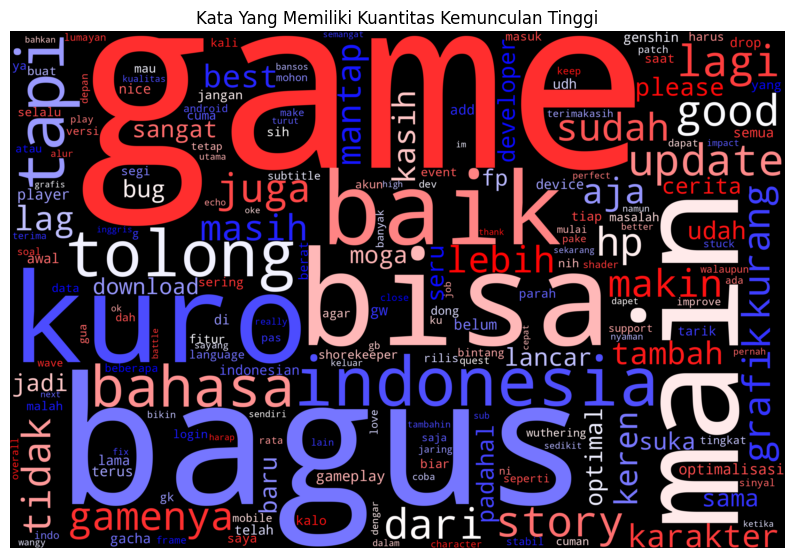

In [56]:
# Visualisasi Kata Yang Memiliki Kuantitas Kemunculan Paling Tinggi

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Kata Yang Memiliki Kuantitas Kemunculan Tinggi')
    plt.axis('off')
    plt.show()

# Memfilter hanya data string yang valid
all_words = ' '.join([str(reviews) for reviews in df_values['stemming'] if isinstance(reviews, str)])

# Membuat WordCloud
wordcloud = WordCloud(width=3000,
                      height=2000,
                      random_state=3,
                      background_color='black',
                      colormap='bwr',
                      collocations=False,
                      stopwords=STOPWORDS).generate(all_words)

# Menampilkan WordCloud
plot_cloud(wordcloud)


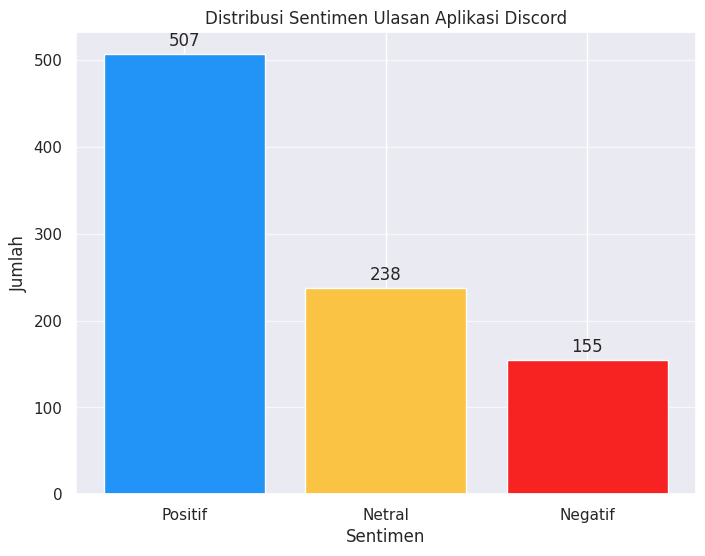

In [57]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Bar Plot

import seaborn as sns

sns.set_theme()

labels = ['Positif', 'Netral', 'Negatif']
counts = [total_positif, total_netral, total_negatif]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#fac343', '#f72323'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='-', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

show_bar_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi Discord")

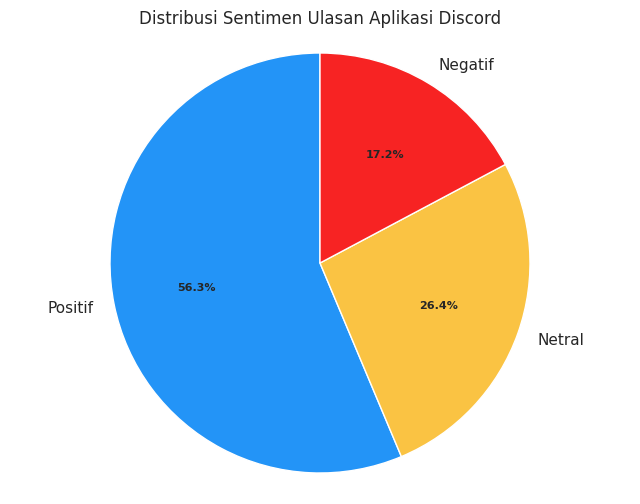

In [58]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Pie Chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

labels = ['Positif', 'Netral', 'Negatif']
counts = [total_positif, total_netral, total_negatif]

def show_pie_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Customize colors for each wedge
    colors = ['#2394f7', '#fac343', '#f72323']

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%',
                                      startangle=90, colors=colors)

    # Customize the wedge properties
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.setp(autotexts, size=8, weight='bold')

    # Add a title
    ax.set_title(title)

    plt.show()

# Call the pie chart function
show_pie_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi Discord")

In [59]:
# Replace Data Sentimen

df_final = df_values.replace({'Positif':0, 'Netral':1, 'Negatif':2})
df_final

,content,cleaning,normalization,stopwords,tokenized,stemming,translate,sentimen,polaritas
0,Mbut,mbut,mbut,mbut,['mbut'],mbut,butt,1,0.000000
1,I change my device and ITS was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,i change my device and its was the best game ever,"['i', 'change', 'my', 'device', 'and', 'its', ...",i change my device and its was the best game ever,i change my device and its was the best game ever,0,0.300000
2,"need material (core) for ascend weapon, resona...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,"['need', 'material', 'core', 'for', 'ascend', ...",need material core for ascend weapon resonator...,need material core for ascend weapon resonator...,1,0.000000
3,"cons :game nya oke, story oke, hp dan grafik k...",cons game nya oke story oke hp dan grafik kena...,cons game nya oke story oke hp dan grafik kena...,cons game oke story oke hp grafik kena high en...,"['cons', 'game', 'oke', 'story', 'oke', 'hp', ...",cons game oke story oke hp grafik kena high en...,cons game okay story okay hp graphics hit high...,0,0.152000
4,"Saya suka sama grafik,story,dan mekanisme game...",saya suka sama grafikstorydan mekanisme gameny...,saya suka sama grafikstorydan mekanisme gameny...,suka sama grafikstorydan mekanisme gamenya bagus,"['suka', 'sama', 'grafikstorydan', 'mekanisme'...",suka sama grafikstorydan mekanisme gamenya bagus,"like the graphics, story and game mechanics ar...",0,0.150000
...,...,...,...,...,...,...,...,...,...
895,Gamenya Mantap banyak Tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap banyak tobrutnya,gamenya mantap tobrutnya,"['gamenya', 'mantap', 'tobrutnya']",gamenya mantap tobrutnya,"the game is awesome, brutal",2,-0.091667
896,"Kamera Pargoy Gak Bisa Di Turn Off, Annoying B...",kamera pargoy gak bisa di turn off annoying bet,kamera pargoy gak bisa di turn off annoying bet,kamera pargoy bisa turn off annoying bet,"['kamera', 'pargoy', 'bisa', 'turn', 'off', 'a...",kamera pargoy bisa turn off annoying bet,pargoy camera can turn off annoying bet,2,-0.800000
897,The best story ð,the best story,the best story,the best story,"['the', 'best', 'story']",the best story,the best story,0,1.000000
898,Game terbaik yg pernah aku temukan,game terbaik yg pernah aku temukan,game terbaik yang pernah aku temukan,game terbaik pernah temukan,"['game', 'terbaik', 'pernah', 'temukan']",game baik pernah temu,good game ever met,0,0.150000


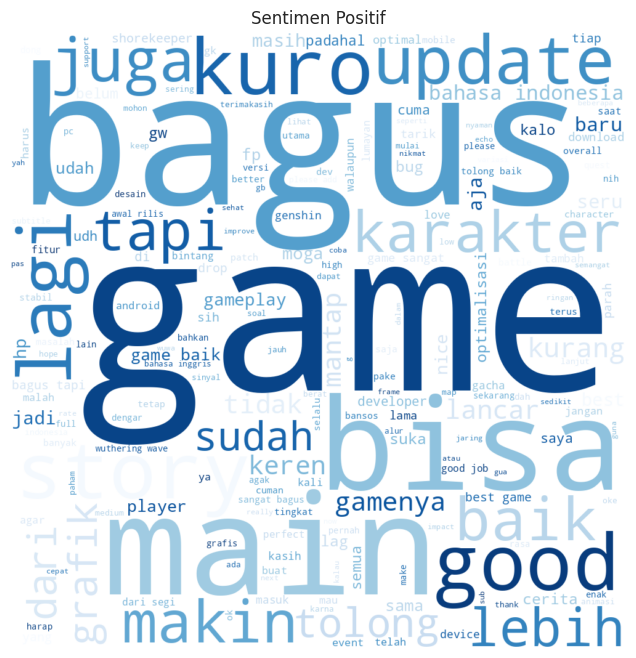

In [60]:
# Visualisasi Wordcould Positif & Negatif

data_positif = df_final[df_final['sentimen'] == 0]
data_netral = df_final[df_final['sentimen'] == 1]
data_negatif = df_final[df_final['sentimen'] == 2]

# Sentimen Positif

all_words = ' '.join([reviews for reviews in data_positif['stemming']])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif")
plt.margins(x=0, y=0)
plt.show()

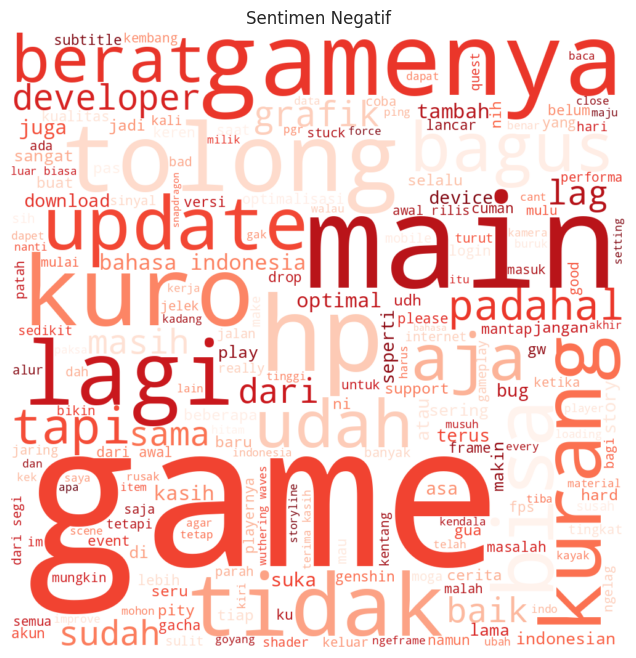

In [61]:
# Sentimen Negatif

all_words = ' '.join([reviews for reviews in data_negatif['stemming']])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif")
plt.margins(x=0, y=0)
plt.show()

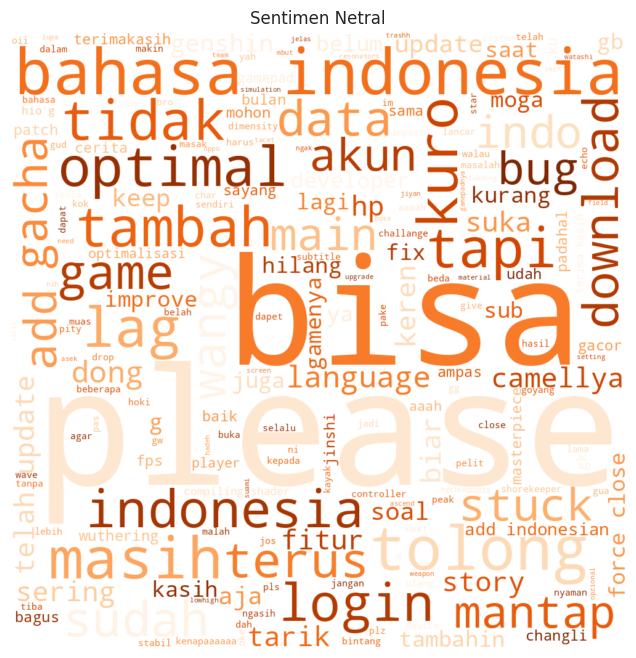

In [62]:
# Sentimen Netral

all_words = ' '.join([str(reviews) for reviews in data_netral['stemming'] if isinstance(reviews, str)])
wordcloud = WordCloud(colormap='Oranges', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Netral")
plt.margins(x=0, y=0)
plt.show()

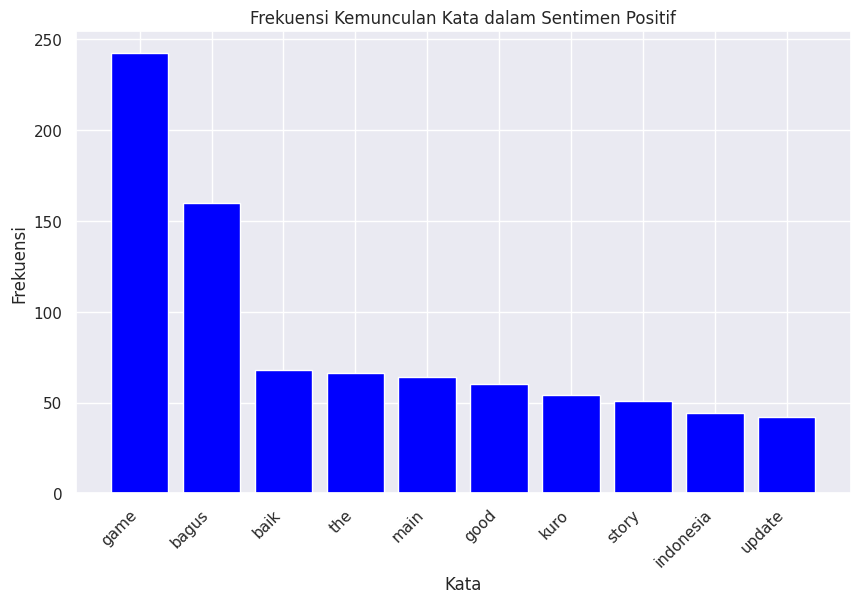

In [63]:
from collections import Counter
import matplotlib.pyplot as plt

# Daftar kata yang ingin dikecualikan
exclude_words = {"bisa", "tolong", "tapi", "tidak", "padahal", "lagi", "jadi", "sama",
                 "ya", "sudah", "juga", "mau", "udah", "kenapa", "saat", "lebih",
                 "dari", "kalo", "pas", "baru", "aja", "malah", "kasih","masuk"}

# Menggabungkan semua teks dari sentimen positif
all_texts_positif = ' '.join(data_positif['stemming'])

# Menghitung frekuensi kata
word_counts = Counter(all_texts_positif.split())

# Menghapus kata-kata yang ada di daftar exclude_words
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in exclude_words}

# Mengambil 10 kata yang paling sering muncul
most_common_words = Counter(filtered_word_counts).most_common(10)

# Membuat barplot
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kemunculan Kata dalam Sentimen Positif')
plt.xticks(rotation=45, ha='right')
plt.show()


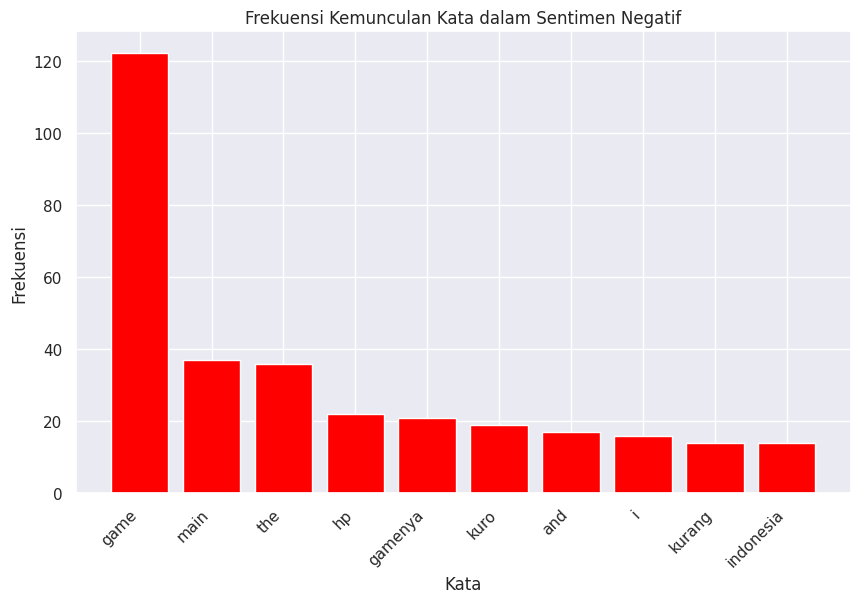

In [64]:
from collections import Counter
import matplotlib.pyplot as plt

# Daftar kata yang ingin dikecualikan
exclude_words = {"bisa", "tolong", "tapi", "tidak", "padahal", "lagi", "jadi", "sama",
                 "ya", "sudah", "juga", "mau", "udah", "kenapa", "saat", "lebih",
                 "dari", "kalo", "pas", "baru", "aja", "malah", "kasih", "masuk", "gk", "terus", "udh", "baik"}

# Menggabungkan semua teks dari sentimen negatif
all_texts_positif = ' '.join(data_negatif['stemming'])

# Menghitung frekuensi kata
word_counts = Counter(all_texts_positif.split())

# Menghapus kata-kata yang ada di daftar exclude_words
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in exclude_words}

# Mengambil 10 kata yang paling sering muncul
most_common_words = Counter(filtered_word_counts).most_common(10)

# Membuat barplot
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='red')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kemunculan Kata dalam Sentimen Negatif')
plt.xticks(rotation=45, ha='right')
plt.show()


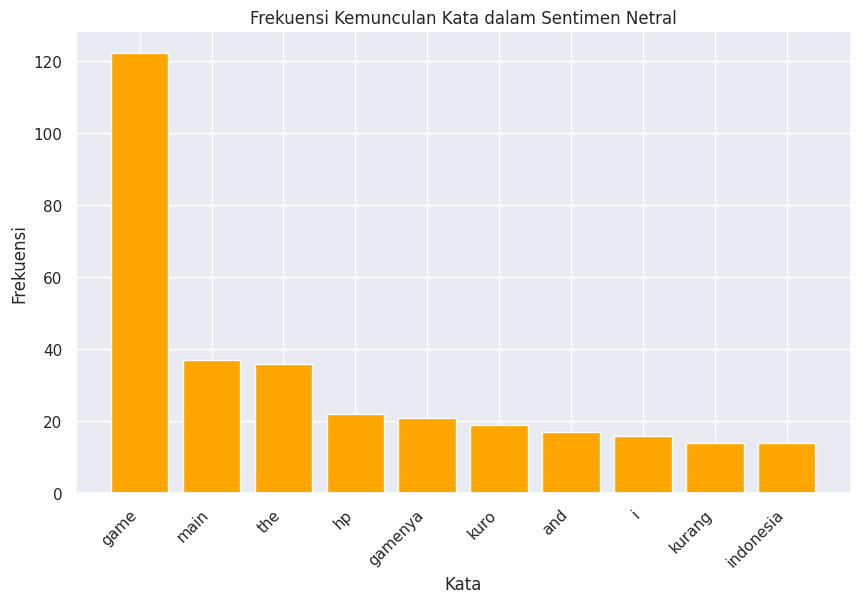

In [65]:
from collections import Counter
import matplotlib.pyplot as plt

# Daftar kata yang ingin dikecualikan
exclude_words = {"bisa", "tolong", "tapi", "tidak", "padahal", "lagi", "jadi", "sama",
                 "ya", "sudah", "juga", "mau", "udah", "kenapa", "saat", "lebih",
                 "dari", "kalo", "pas", "baru", "aja", "malah", "kasih", "masuk", "gk", "terus", "udh", "baik",
                 "kok", "mohon", "telah"}

# Memfilter data yang valid (hanya string)
all_texts_netral = ' '.join([str(text) for text in data_netral['stemming'] if isinstance(text, str)])

# Menghitung frekuensi kata
word_counts = Counter(all_texts_positif.split())

# Menghapus kata-kata yang ada di daftar exclude_words
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in exclude_words}

# Mengambil 10 kata yang paling sering muncul
most_common_words = Counter(filtered_word_counts).most_common(10)

# Membuat barplot
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='orange')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Frekuensi Kemunculan Kata dalam Sentimen Netral')
plt.xticks(rotation=45, ha='right')
plt.show()


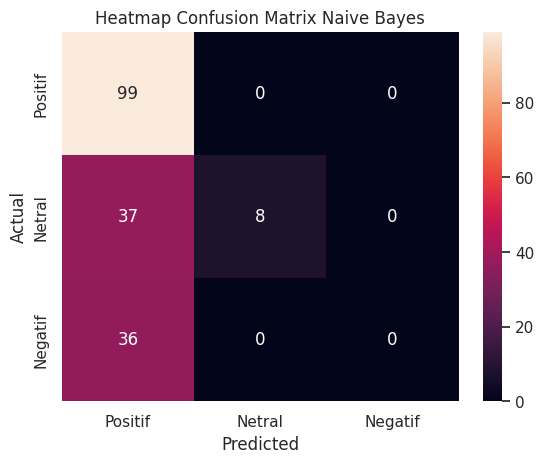

In [66]:
# Visualisasi Heatmap Confusion Matrix

cm_matrix = pd.DataFrame(data=cmnb, columns=['Positif', 'Netral', 'Negatif'],
                         index=['Positif', 'Netral', 'Negatif'])

sns.heatmap(cm_matrix, annot=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Heatmap Confusion Matrix Naive Bayes')
plt.show()

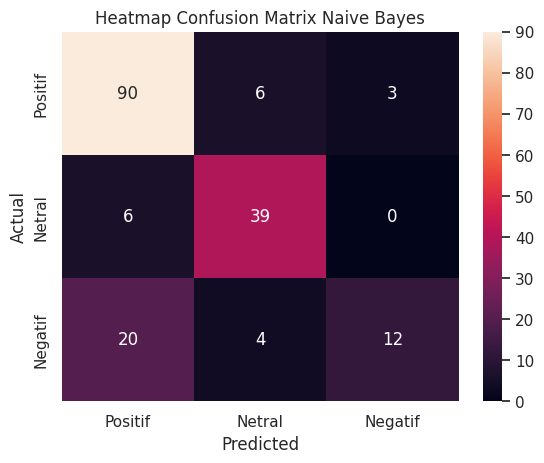

In [67]:
# Visualisasi Heatmap Confusion Matrix

cm_matrix = pd.DataFrame(data=cmsvm, columns=['Positif', 'Netral', 'Negatif'],
                         index=['Positif', 'Netral', 'Negatif'])

sns.heatmap(cm_matrix, annot=True, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Heatmap Confusion Matrix Naive Bayes')
plt.show()

# **Simpan Model dan Vectorizer Ke Pickle**

In [ ]:
import joblib

# Simpan model Naive Bayes
joblib.dump(svm_model, 'support_vector_machine_model_6.pkl')

# Simpan TF-IDF Vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer_6.pkl')

print("Model dan vectorizer berhasil disimpan!")


Model dan vectorizer berhasil disimpan!


In [ ]:
# Cek versi library yang digunakan
import sys
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import seaborn

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {seaborn.__version__}")

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
NumPy version: 1.26.4
Pandas version: 2.2.2
Scikit-learn version: 1.5.2
Matplotlib version: 3.7.1
Seaborn version: 0.13.2
